https://github.com/farhanafayez/PySpark-K-means-Clustering-ML

This jupyter notebook consists a project which implemets K mean clustering with PySpark. Meta data of each session showed that the hackers used to connect to their servers were found, for system that was breached. This data is used whether to identify whether 2 or 3 hackers were involved of the potential 3 hackers

In [2]:
import os
import sys
from pyspark.context import SparkContext,SparkConf
from pyspark.rdd import RDD
!pip install psutil
import psutil
#若沒有下面這段
#會有Exception: Java gateway process exited before sending its port number
#Config
os.environ['JAVA_HOME'] = 'C:\Program Files\Java\jre1.8.0_301'
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable


sc = SparkContext(conf=SparkConf().setAppName("Kmeans").setMaster("local"))
print(f'sc:{sc}')
spark = SparkSession(sc)


You should consider upgrading via the 'c:\users\leoshr\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


sc:<SparkContext master=local appName=Kmeans>


In [3]:
path = r'C:\Users\LeoShr\p_space\NTHU\MDA\CH3_K_means\Project\K-means-clustering-using-pyspark-main\hack_data.csv'
data = spark.read.csv(path,header=True,inferSchema=True)



In [4]:
# data_path = r'C:\Users\LeoShr\p_space\NTHU\MDA\CH3_K_means\Project\K-means-clustering-using-pyspark-main\hack_data.csv'
# data = spark.read.csv('data_path',header=True,inferSchema=True)
# import csv
# files = open(r'C:\Users\LeoShr\p_space\NTHU\MDA\CH3_K_means\Project\K-means-clustering-using-pyspark-main\hack_data.csv','r', encoding = 'UTF-8')
# files
# dd = csv.reader(files)
# print(list(dd))

#### Data exploration

In [5]:
data.printSchema()

root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)



In [6]:
data.head(1)

[Row(Session_Connection_Time=8.0, Bytes Transferred=391.09, Kali_Trace_Used=1, Servers_Corrupted=2.96, Pages_Corrupted=7.0, Location='Slovenia', WPM_Typing_Speed=72.37)]

### Creating features vector

In [7]:
from pyspark.ml.feature import VectorAssembler
data.columns

['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
 'Location',
 'WPM_Typing_Speed']

In [8]:
assembler = VectorAssembler(inputCols=['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
 'WPM_Typing_Speed'], outputCol='features')

In [9]:
final_data = assembler.transform(data)
final_data.printSchema()

root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)
 |-- features: vector (nullable = true)



### Scaling the data

In [10]:
from pyspark.ml.feature import StandardScaler

In [11]:
scaler = StandardScaler(inputCol='features',outputCol='scaledFeat')

In [12]:
final_data = scaler.fit(final_data).transform(final_data)

In [13]:
final_data.printSchema()

root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaledFeat: vector (nullable = true)



### K-means clustering model

In [14]:
from pyspark.ml.clustering import KMeans

In [15]:
# let's try with the assumption that there were two hacker groups
kmeans = KMeans(featuresCol='scaledFeat',k=2)

In [16]:
model = kmeans.fit(final_data)

In [17]:
centers = model.clusterCenters()
print(centers)

[array([2.99991988, 2.92319035, 1.05261534, 3.20390443, 4.51321315,
       3.28474   ]), array([1.26023837, 1.31829808, 0.99280765, 1.36491885, 2.5625043 ,
       5.26676612])]


In [18]:
results = model.transform(final_data)

In [19]:
results.printSchema()

root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaledFeat: vector (nullable = true)
 |-- prediction: integer (nullable = false)



In [20]:
results.describe().show()

+-------+-----------------------+------------------+------------------+-----------------+------------------+-----------+------------------+------------------+
|summary|Session_Connection_Time| Bytes Transferred|   Kali_Trace_Used|Servers_Corrupted|   Pages_Corrupted|   Location|  WPM_Typing_Speed|        prediction|
+-------+-----------------------+------------------+------------------+-----------------+------------------+-----------+------------------+------------------+
|  count|                    334|               334|               334|              334|               334|        334|               334|               334|
|   mean|     30.008982035928145| 607.2452694610777|0.5119760479041916|5.258502994011977|10.838323353293413|       null|57.342395209580864|               0.5|
| stddev|     14.088200614636158|286.33593163576757|0.5006065264451406| 2.30190693339697|  3.06352633036022|       null| 13.41106336843464|0.5007501879687625|
|    min|                    1.0|             

In [21]:
results.groupBy('prediction').count().show()
# This shows that the attack was equaly sheared by the hacker groups

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  167|
|         0|  167|
+----------+-----+



### Graphical visualization of the clusters

In [22]:
!python -V 
!pip install pandas
import pandas

Python 3.9.0


You should consider upgrading via the 'c:\users\leoshr\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [23]:
!pip install matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

You should consider upgrading via the 'c:\users\leoshr\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [24]:
results_pd = results.toPandas()
results_pd

,Session_Connection_Time,Bytes Transferred,Kali_Trace_Used,Servers_Corrupted,Pages_Corrupted,Location,WPM_Typing_Speed,features,scaledFeat,prediction
0,8.0,391.09,1,2.96,7.0,Slovenia,72.37,"[8.0, 391.09, 1.0, 2.96, 7.0, 72.37]","[0.5678510846650524, 1.3658432518957642, 1.997...",1
1,20.0,720.99,0,3.04,9.0,British Virgin Islands,69.08,"[20.0, 720.99, 0.0, 3.04, 9.0, 69.08]","[1.419627711662631, 2.517986463945197, 0.0, 1....",1
2,31.0,356.32,1,3.71,8.0,Tokelau,70.58,"[31.0, 356.32, 1.0, 3.71, 8.0, 70.58]","[2.2004229530770782, 1.2444124562517545, 1.997...",1
3,2.0,228.08,1,2.48,8.0,Bolivia,70.80,"[2.0, 228.08, 1.0, 2.48, 8.0, 70.8]","[0.1419627711662631, 0.7965469045293562, 1.997...",1
4,20.0,408.50,0,3.57,8.0,Iraq,71.28,"[20.0, 408.5, 0.0, 3.57, 8.0, 71.28]","[1.419627711662631, 1.4266459597520256, 0.0, 1...",1
...,...,...,...,...,...,...,...,...,...,...
329,39.0,761.91,1,6.99,14.0,Belarus,43.23,"[39.0, 761.91, 1.0, 6.99, 14.0, 43.23]","[2.7682740377421307, 2.660895528016318, 1.9975...",0
330,43.0,983.48,0,8.60,13.0,British Indian Ocean Territory (Chagos Archipe...,43.21,"[43.0, 983.48, 0.0, 8.6, 13.0, 43.21]","[3.0521995800746566, 3.4347068996252683, 0.0, ...",0
331,39.0,690.22,1,6.80,13.0,Guinea-Bissau,42.75,"[39.0, 690.22, 1.0, 6.8, 13.0, 42.75]","[2.7682740377421307, 2.4105252737822354, 1.997...",0
332,36.0,1060.69,1,6.26,14.0,Canada,43.86,"[36.0, 1060.69, 1.0, 6.26, 14.0, 43.86]","[2.555329880992736, 3.704355209423197, 1.99757...",0


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

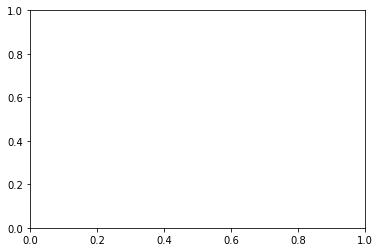

In [25]:
plot = plt.scatter(data=results_pd, x=results_pd.index, y=results_pd['Bytes Transferred'],c=results_pd['prediction'])
plt.ylabel('Bytes Transferred')

In [27]:
import pandas as pd
df = pd.DataFrame([
        (1, 531, True, 12.8),
        (2, 126, False, 74.2),
        (3, 175, False, 1.1),
        (4, 127, True, 45.8),
        (5, 543, True, 21.1),
        (6, 254, False, 98.1),
    ],columns=['colA', 'colB', 'colC', 'colD'])
print(df)

   colA  colB   colC  colD
0     1   531   True  12.8
1     2   126  False  74.2
2     3   175  False   1.1
3     4   127   True  45.8
4     5   543   True  21.1
5     6   254  False  98.1


In [30]:
df[df['colB']>200]

,colA,colB,colC,colD
0,1,531,True,12.8
4,5,543,True,21.1
5,6,254,False,98.1


In [32]:
df[df['colD'] <= 50]

,colA,colB,colC,colD
0,1,531,True,12.8
2,3,175,False,1.1
3,4,127,True,45.8
4,5,543,True,21.1


In [33]:
df = df[(df['colB'] > 200) and (df['colD'] <= 50)

SyntaxError: unexpected EOF while parsing (Temp/ipykernel_13356/4154032455.py, line 1)